In [0]:
"""
   ___                  _                
  / _/______ ____  ____(_)__ _______     
 / _/ __/ _ `/ _ \/ __/ (_-</ __/ _ \    
/_//_/  \_,_/_//_/\__/_/___/\__/\___/    
  ___ _____(_)__ ___ ____  / /_(_)       
 / _ `/ __/ (_-</ _ `/ _ \/ __/ /        
 \_, /_/ /_/___/\_,_/_//_/\__/_/         
/___/


franciscogrisanti.com

"""

In [90]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# ###PART 1 Clean & Fill

In [0]:


###Loading libraries

import pandas as pd
import numpy as np
from sklearn.impute import SimpleImputer

def clean_fill(data):
 
    ###Drop NaN of categorical values
    
    data = data.dropna(subset=['x34','x35','x68','x93'])
    
    ###Remove "$" from column x41
    
    data['x41'] = data['x41'].astype(str)
    data['x41'] = data['x41'].apply(lambda x: x.replace('$',' '))
    data['x41'] = data['x41'].astype(float)
           
    ###Remove "%" from column x45
    
    data['x45'] = data['x45'].astype(str)
    data['x45'] = data['x45'].apply(lambda x: x.replace('%',' '))
    data['x45'] = data['x45'].astype(float)
    
    ###Clean car brand column x34
    
    data['x34'] = data['x34'].astype(str)
    data['x34'] = data['x34'].apply(lambda x: x.replace('mercades','mercedes'))
    data['x34'] = data['x34'].apply(lambda x: x.replace('chrystler','chrysler'))
    data['x34'] = data['x34'].apply(lambda x: x.replace('volkswagon','volkswagen'))
    
    ###Clean week days column x35
    
    data['x35'] = data['x35'].astype(str)
    data['x35'] = data['x35'].apply(lambda x: x.replace('day',''))
    data['x35'] = data['x35'].apply(lambda x: x.replace('nes',''))
    
    ###Clean months column x68
    
    data['x68'] = data['x68'].astype(str)   
    data['x68'] = data['x68'].apply(lambda x: x.replace('January','january')) 
    data['x68'] = data['x68'].apply(lambda x: x.replace('Feb','february')) 
    data['x68'] = data['x68'].apply(lambda x: x.replace('Mar','march'))
    data['x68'] = data['x68'].apply(lambda x: x.replace('Apr','april'))
    data['x68'] = data['x68'].apply(lambda x: x.replace('May','may'))
    data['x68'] = data['x68'].apply(lambda x: x.replace('Jun','june')) 
    data['x68'] = data['x68'].apply(lambda x: x.replace('Aug','august')) 
    data['x68'] = data['x68'].apply(lambda x: x.replace('sept.','september')) 
    data['x68'] = data['x68'].apply(lambda x: x.replace('Oct','october')) 
    data['x68'] = data['x68'].apply(lambda x: x.replace('Nov','november')) 
    data['x68'] = data['x68'].apply(lambda x: x.replace('Dev','december'))
     
    ###Clean continent column x93
    
    data['x93'] = data['x93'].astype(str)   
    data['x93'] = data['x93'].apply(lambda x: x.replace('euorpe','europe'))
    
    ###Get categorical, numerical and all variables list
    
    all_variables = list(data.keys())
    numerical_variables = list(data._get_numeric_data().keys())
    categorical_columns = all_variables.copy()
    
    for i in all_variables:
        if i in numerical_variables:
            categorical_columns.remove(i)
    
    del i
    
    ###Drop categorical columns to use imputer on missing values
    
    df_processed = data.drop(columns=categorical_columns)
    
    ###Fill NaN with mean values


    imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
    imp_mean.fit(df_processed)
    
    columns = list(df_processed.columns)
    
    df_processed  = imp_mean.transform(df_processed)
    
    df_processed_filled = pd.DataFrame(data=df_processed, columns= columns)
       
    df_processed_filled =  df_processed_filled.join(data[categorical_columns])  
    
    df_processed_filled = df_processed_filled.reindex(sorted(df_processed_filled.columns), axis=1)
    
    return df_processed_filled

# ###PART 2 Encoding

In [0]:
###PART 2 Encoding
    
###Loading libraries
    
from sklearn.preprocessing import LabelEncoder, OneHotEncoder



In [0]:

def encoding(data , data_testing):    
    
    ###Get categorical, numerical and all variables list
    
    all_variables = list(data.keys())
    numerical_variables = list(data._get_numeric_data().keys())
    categorical_columns = all_variables.copy()
    
    for i in all_variables:
        if i in numerical_variables:
            categorical_columns.remove(i)
            
    ###For each categorical column we fit a label encoder, transform our column and add it to our new dataframe

    label_encoders = {}
    
    for col in categorical_columns:
        print("Encoding {}".format(col))
        new_le = LabelEncoder()
        data[col] = new_le.fit_transform(data[col].astype(str))
        label_encoders[col] = new_le
    
    ###Categorical columns index positions
        
    categorical_columns_idx = [data.columns.get_loc(col) for col in categorical_columns]
    
    ###For each categorical column we set we use one hot encoder to perform “binarization” of the category 
    
    ohe = OneHotEncoder(categorical_features=categorical_columns_idx,sparse=False, handle_unknown="ignore",n_values='auto')
    
    ###We fit the transform to our data 
    
    data_train_np = ohe.fit_transform(data) 
    
    ###We encode the same label encoder to  our data testing data (we dont make a new fit, we transform our categorical variables with previous fit)

    for col in categorical_columns:
        print("Encoding {}".format(col))
        data_testing[col] = label_encoders.get(col).transform(data_testing[col].astype(str))
    
    ###Categorical columns index positions
        
    categorical_columns_idx = [data_testing.columns.get_loc(col) for col in categorical_columns]
    
    ###We fit the previous one hot encoder to our testing dataset
    
    data_testing_np = ohe.transform(data_testing)
       
    ###Pass everything to a dataframe
    
    data_train_np_df = pd.DataFrame(data_train_np)
    data_testing_np_df = pd.DataFrame(data_testing_np)
    
    return data_train_np_df , data_testing_np_df



# **###PART 3 Ensemble ML Model**

In [0]:
###PART 3 Ensemble ML Model
    
###Loading libraries

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import pickle
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)


def ensemble_model(X_train, X_test, y_train, y_test):
    
    
    #create new a knn model
    knn = KNeighborsClassifier()
    
    #create a dictionary of all values we want to test for n_neighbors
    
    params_knn = {'n_neighbors': np.arange(1, 5)}
    #use gridsearch to test all values for n_neighbors
    knn_gs = GridSearchCV(knn, params_knn, cv=5)
    
    #fit model to training data
    knn_gs.fit(X_train, y_train)
    
    #save best model
    knn_best = knn_gs.best_estimator_
    
    #check best n_neigbors value
    print(knn_gs.best_params_)
    
    #create a new rf classifier
    rf = RandomForestClassifier()
    
    #create a dictionary of all values we want to test for n_estimators
    params_rf = {'n_estimators': [200]}
    
    #use gridsearch to test all values for n_estimators
    rf_gs = GridSearchCV(rf, params_rf, cv=5)
    
    #fit model to training data
    rf_gs.fit(X_train, y_train)  
    
    #save best model
    rf_best = rf_gs.best_estimator_
    
    #check best n_estimators value
    print(rf_gs.best_params_)
    
    #create a new logistic regression model
    log_reg = LogisticRegression(solver='liblinear')
    
    #fit the model to the training data
    log_reg.fit(X_train, y_train)
    
    #test the three models with the test data and print their accuracy scores
    print('knn: {}'.format(knn_best.score(X_test, y_test)))
    print('rf: {}'.format(rf_best.score(X_test, y_test)))
    print('log_reg: {}'.format(log_reg.score(X_test, y_test)))
    
    #create a dictionary of our models
    estimators=[('knn', knn_best), ('rf', rf_best), ('log_reg', log_reg)]
    
    #create our voting classifier, inputting our models
    ensemble = VotingClassifier(estimators, voting='soft')
    
    #fit model to training data
    ensemble.fit(X_train, y_train)
    
    #test our model on the test data
    ensemble.score(X_test, y_test)
    
    filename = 'finalized_model_ensemble.sav'
    pickle.dump(ensemble, open(filename, 'wb'))
    
    return ensemble



# ###PART 4 deep learning model

In [0]:
###PART 4 deep learning model
    
###Loading libraries
from keras import Sequential
from keras.layers import Dense
from keras.utils.vis_utils import plot_model

    
def deep_learning(X_train, X_test, y_train, y_test):
    
    ###initialize sequential
    classifier = Sequential()
    #First Hidden Layer
    classifier.add(Dense(20, activation='relu', kernel_initializer='random_normal', input_dim=130))
    #Second  Hidden Layer
    classifier.add(Dense(20, activation='relu', kernel_initializer='random_normal'))
    #Output Layer
    classifier.add(Dense(1, activation='sigmoid', kernel_initializer='random_normal'))
    
    
    #plot arquitecture
    #plot_model(classifier, to_file='model_plot.png', show_shapes=True, show_layer_names=True)
    
    
    #Compiling the neural network
    classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])
    
    #Fitting the data to the training dataset
    classifier.fit(X_train,y_train, batch_size=10, epochs=30)
    
    #eval model
    eval_model=classifier.evaluate(X_train, y_train)
    eval_model #Loss and accuracy of the model
    
    filename = 'finalized_model_NN.sav'
    
    return pickle.dump(classifier, open(filename, 'wb'))
    


# ###PART 5 load model evaluation

In [0]:
###PART 5 load model evaluation

def load_model(filename):
    loaded_model = pickle.load(open(filename, 'rb'))
    return loaded_model



# ####PART 6 Model evaluation

In [0]:
####PART 6 Model evaluation
    
### Ensemble evaluation

def evaluate_ensemble(model,X_test,y_test):
    
    result = model.score(X_test, y_test)
    
    return result
    
### Ensemble evaluation
    
def evaluate_deep_learning_model(model,X_test,y_test):
    
    result= model.evaluate(X_test, y_test)
    
    return result

# ####PART 7 Model prediction

In [0]:
####PART 7 Model prediction

def predict_ensemble(model,X_test):
    
    predictions_prob = model.predict_proba(X_test)[:,1]
    
    predictions_prob_df = pd.DataFrame(predictions_prob)
        
    return predictions_prob_df



def predict_deep_learning(model,X_test):
    
    predictions_prob = model.predict_proba(X_test)
    
    predictions_prob_df = pd.DataFrame(predictions_prob)
        
    return predictions_prob_df

# **create results**

In [99]:
####FINAL CREATE RESULTS
    
data_train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Code_challenge_train.csv")
data_predict = pd.read_csv("/content/drive/My Drive/Colab Notebooks/Code_challenge_test.csv")

data_train.head()

,x0,x1,x2,x3,x4,x5,x6,x7,x8,x9,x10,x11,x12,x13,x14,x15,x16,x17,x18,x19,x20,x21,x22,x23,x24,x25,x26,x27,x28,x29,x30,x31,x32,x33,x34,x35,x36,x37,x38,x39,...,x61,x62,x63,x64,x65,x66,x67,x68,x69,x70,x71,x72,x73,x74,x75,x76,x77,x78,x79,x80,x81,x82,x83,x84,x85,x86,x87,x88,x89,x90,x91,x92,x93,x94,x95,x96,x97,x98,x99,y
0,-17.933519,6.559220,2.422468,-27.737392,-12.080601,-3.892934,1.067466,0.935953,10.912007,1.107144,-6.930959,1.216195,-3.201791,-2.554698,18.641967,4.355568,2.930575,-8.837017,11.130022,29.003277,28.067383,6.858563,6.639400,-11.902308,1.972676,-2.209551,13.751183,-53.210769,0.118928,-2.378699,-1.363484,6.198709,-3.303896,-14.452810,bmw,thur,-4.732855,0.381673,3.315615,2.126180,...,-1.848540,-10.420598,-43.472100,-4.234014,0.228835,-4.992379,-0.730363,sept.,113.609078,27.357033,7.089389,35.714730,3.203123,-30.367210,-6.438588,13.607362,-14.699618,17.981694,2.307000,-49.668818,6.888126,11.126120,33.192869,5.516509,8.060383,10.164888,-0.945972,-0.268380,-1.395421,-94.582358,11.107047,0.093337,asia,0.421524,35.259947,8.994318,-21.000182,-0.686588,2.949106,1
1,-37.214754,10.774930,5.404072,21.354738,0.612690,-3.093533,6.161558,-0.972156,-5.222169,0.384969,55.127380,0.226435,0.080309,-6.158352,-0.068433,0.671255,1.047602,11.512884,22.593810,30.730435,22.691932,1.638203,22.992367,-3.426358,-4.425386,-21.848389,-15.585629,23.278298,5.798608,-0.744079,-1.127306,-6.110792,11.449099,-15.384004,Toyota,wednesday,-0.077339,10.983774,6.411503,3.849885,...,5.532411,-6.463038,-13.503320,-0.856349,5.708973,0.956286,-0.438181,July,-83.422420,-9.414394,19.078639,0.201859,20.001259,-8.073947,30.530882,21.408708,-10.026045,-31.950461,-1.667241,14.056597,-2.625740,-18.588051,-35.209305,13.131763,-4.127880,-7.792043,-1.058691,0.091408,-4.768139,1.474587,-1.991846,15.666187,asia,-0.132764,-1.192563,3.885024,-37.886523,-7.730392,-1.107330,0
2,0.330441,-19.609972,-1.331804,-15.153892,19.710240,19.077300,-1.747110,0.545570,-1.464609,3.670570,-23.198723,-1.728167,0.194729,15.425624,-7.377787,-5.148825,7.518404,-4.618872,47.039602,37.531334,29.281857,-11.966419,-69.006396,13.458467,-7.598210,15.585958,1.375171,33.139124,5.316062,-2.618426,0.275117,0.925513,-1.719141,-9.167911,bmw,thurday,2.064124,12.071688,7.392408,-2.868111,...,-1.131575,13.972549,4.184259,1.178784,19.211008,-2.178992,-2.838677,July,-19.443606,57.715255,9.642057,-35.606532,6.066999,41.019791,-4.474584,-12.992872,2.485948,25.453160,-2.649664,13.336220,7.007135,-9.323044,-15.221544,1.545009,-0.146546,-0.975971,4.217668,-0.196222,1.019800,5.160726,17.132840,-5.333012,asia,1.432308,-3.435427,-1.133450,7.426099,-5.945534,1.316312,0
3,-13.709765,-8.011390,-1.536483,23.129497,27.880879,20.573991,-1.617689,4.129694,1.139928,2.912838,-4.266473,-0.611641,-2.266844,-4.727266,1.947570,-7.887527,10.183794,-5.534296,70.134427,20.739051,-9.891156,-3.115887,-45.203496,11.721152,-0.891464,16.215744,-17.894719,14.483436,0.268279,1.632825,0.648522,-3.691137,1.713175,6.759264,Toyota,wed,1.727615,-1.768382,-2.833059,0.237976,...,9.685368,4.275216,23.696119,6.931587,-0.978046,-3.046061,0.088251,Apr,-38.573263,17.024405,21.338080,-30.778710,-3.442964,-7.106684,-33.571893,10.145435,6.098920,17.204587,-2.067339,-5.448625,-1.949064,-1.242046,-24.449297,11.268342,-3.066738,-6.402145,2.117924,0.336568,-0.868633,-26.589765,12.292136,4.177925,asia,0.733069,4.372964,15.529931,29.712153,2.240740,0.477195,0
4,-4.202598,7.076210,8.881550,23.600777,26.232164,-14.462320,3.231193,-0.069364,-7.310536,-2.268700,1.134867,1.074985,-0.937646,-2.092563,-3.835046,4.566927,2.011431,-1.002053,-23.097300,13.771753,9.592197,-4.136528,-16.266403,-6.009268,3.941376,-8.488938,3.658352,-9.011427,-4.274480,0.280249,-0.218360,3.195555,3.160442,-26.004919,Toyota,wednesday,-4.269696,-3.414224,0.864827,-8.271576,...,-0.137332,-9.436784,-9.919847,1.357206,3.369164,2.070446,-2.959965,Aug,-49.138305,46.246520,7.806416,-3.127775,10.798833,38.876795,-1.159631,11.284698,13.679140,27.647763,2.214562,19.447361,17.971631,-1.338839,-15.760102,-4.

,Total,Percent
x55,16,0.000400
x96,15,0.000375
x21,15,0.000375
x18,13,0.000325
x63,13,0.000325


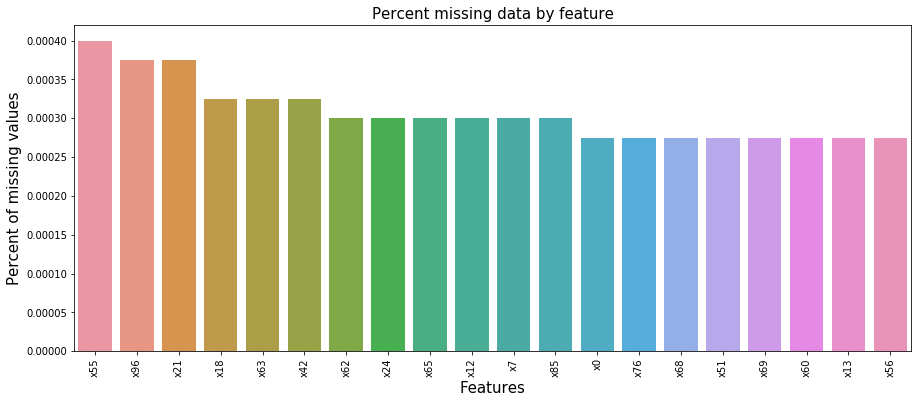

In [100]:
import matplotlib.pyplot as plt
import seaborn as sns

total = data_train.isnull().sum().sort_values(ascending=False)
percent = (data_train.isnull().sum()/data_train.isnull().count()).sort_values(ascending=False)

missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

f, ax = plt.subplots(figsize=(15, 6))


plt.xticks(rotation='90')
sns.barplot(x=missing_data[:20].index, y=missing_data['Percent'][:20])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)
missing_data.head()



In the above picture we can see the 20th biggest percentages of missing values across all feature vectors. Although not much in percentage (>5%), we procede to impute mean values across all missing values.

In [0]:
#Clean and fill datasets
data_train_cleaned = clean_fill(data_train)
data_predict_cleaned = clean_fill(data_predict)

In [102]:
#Encode datasets
data_train_encoded, data_predict_encoded =  encoding(data_train_cleaned , data_predict_cleaned)


/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:391: DeprecationWarning: Passing 'n_values' is deprecated in version 0.20 and will be removed in 0.22. n_values='auto' can be replaced with categories='auto'.
  warnings.warn(msg, DeprecationWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:451: DeprecationWarning: The 'categorical_features' keyword is deprecated in version 0.20 and will be removed in 0.22. You can use the ColumnTransformer instead.
  "use the ColumnTransformer instead.", DeprecationWarning)


Encoding x34
Encoding x35
Encoding x68
Encoding x93
Encoding x34
Encoding x35
Encoding x68
Encoding x93


# #Split data into testing and training

In [0]:
X_train, X_test, y_train, y_test = train_test_split(data_train_encoded.drop([130], axis=1), data_train_encoded[130], test_size=0.30, random_state=0)

# #train and save models to disk

In [116]:
ensemble = ensemble_model(X_train, X_test, y_train, y_test)

{'n_neighbors': 3}
{'n_estimators': 200}
knn: 0.8578697139044124
rf: 0.8680457085661857
log_reg: 0.8886479272666611


In [105]:
deep_learning(X_train, X_test, y_train, y_test)

Epoch 1/30
27974/27974 [==============================] - 4s 151us/step - loss: 0.2132 - acc: 0.9147
Epoch 2/30
27974/27974 [==============================] - 4s 129us/step - loss: 0.1036 - acc: 0.9681
Epoch 3/30
27974/27974 [==============================] - 4s 127us/step - loss: 0.0858 - acc: 0.9748
Epoch 4/30
27974/27974 [==============================] - 4s 128us/step - loss: 0.0772 - acc: 0.9788
Epoch 5/30
27974/27974 [==============================] - 4s 127us/step - loss: 0.0702 - acc: 0.9816
Epoch 6/30
27974/27974 [==============================] - 4s 127us/step - loss: 0.0665 - acc: 0.9827
Epoch 7/30
27974/27974 [==============================] - 4s 125us/step - loss: 0.0615 - acc: 0.9839
Epoch 8/30
27974/27974 [==============================] - 4s 128us/step - loss: 0.0593 - acc: 0.9851
Epoch 9/30
27974/27974 [==============================] - 4s 128us/step - loss: 0.0577 - acc: 0.9850
Epoch 10/30
27974/27974 [==============================] - 4s 128us/step - loss: 0.0550 - a

# #load trained models

In [0]:
#ensemble_pickle = load_model('/content/drive/My Drive/Colab Notebooks/finalized_model_ensemble.sav')

ensemble_pickle = ensemble

In [0]:
deep_learning_pickle = load_model('/content/drive/My Drive/Colab Notebooks/finalized_model_NN.sav')

# #evaluate trained models

In [119]:
ensemble_score = evaluate_ensemble(ensemble_pickle,X_train,y_train)
ensemble_score

0.9691856724100951

In [120]:
ensemble_score = evaluate_ensemble(ensemble_pickle,X_test,y_test)
ensemble_score

0.8994077904746017

In [121]:
deep_learning_score = evaluate_deep_learning_model(deep_learning_pickle,X_train,y_train)

print('Loss & accuraccy')
deep_learning_score

27974/27974 [==============================] - 1s 30us/step
Loss & accuraccy


[0.016340568015849814, 0.9956030599842711]

In [122]:
deep_learning_score = evaluate_deep_learning_model(deep_learning_pickle,X_test,y_test)

print('Loss & accuraccy')
deep_learning_score

11989/11989 [==============================] - 0s 24us/step
Loss & accuraccy


[0.11309239327814655, 0.9793143715072149]

# #ROC - Ensemble

AUC: 0.957


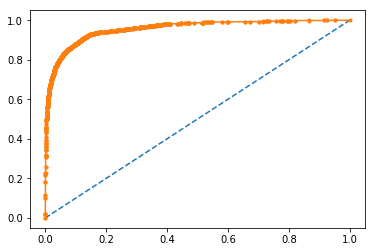

In [123]:
# roc curve and auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot


# predict probabilities
probs = ensemble_pickle.predict_proba(X_test)
# keep probabilities for the positive outcome only
probs = probs[:, 1]

# calculate AUC
auc = roc_auc_score(y_test, probs)

print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

#ROC - Deep Learning

AUC: 0.986


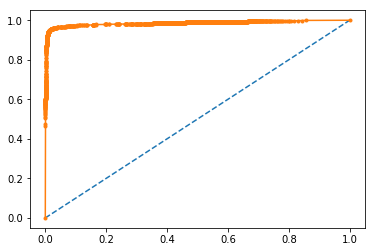

In [126]:

# predict probabilities
probs = deep_learning_pickle.predict_proba(X_test)
# keep probabilities for the positive outcome only
#probs = probs[:, 1]

# calculate AUC
auc = roc_auc_score(y_test, probs)

print('AUC: %.3f' % auc)
# calculate roc curve
fpr, tpr, thresholds = roc_curve(y_test, probs)
# plot no skill
pyplot.plot([0, 1], [0, 1], linestyle='--')
# plot the roc curve for the model
pyplot.plot(fpr, tpr, marker='.')
# show the plot
pyplot.show()

# #predict test data

In [128]:
predictions_ensemble = predict_ensemble(ensemble_pickle , data_predict_encoded)

predictions_ensemble.describe()


,0
count,9996.000000
mean,0.190962
std,0.195989
min,0.002327
25%,0.049305
50%,0.110422
75%,0.259987
max,0.928046


In [0]:
predictions_ensemble.to_csv("/content/drive/My Drive/Colab Notebooks/results1.csv",index=False)

In [130]:
predictions_NN = predict_deep_learning(deep_learning_pickle , data_predict_encoded)

predictions_NN.describe()

,0
count,9996.000000
mean,0.199206
std,0.391314
min,0.000000
25%,0.000002
50%,0.000156
75%,0.012232
max,1.000000


In [0]:
predictions_NN.to_csv("/content/drive/My Drive/Colab Notebooks/results2.csv",index=False)